In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler,NearMiss
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score, recall_score, precision_score
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


##### Считывание данных из файлов

In [2]:
trainTable = pd.read_csv('train.csv')
testTable = pd.read_csv('test.csv')
holdoutTable = pd.read_csv('hold-out dataset.csv')

testTable.drop(['ID'],axis = 1, inplace = True)

##### Признаки с максимальной корреляцией из 1ой недели

In [3]:
#признаки с максимальной корреляцией с целевой переменной
maxCorrFloatFeatures = ['Var153','Var38',
                         'Var113','Var76','Var131','Var133','Var134','Var163','Var149','Var81','Var53',
                         'Var98','Var111','Var28','Var126','Var123','Var83','Var132','Var50','Var35']

maxCorrCatFeatures = ['Var192','Var216',
                     'Var206','Var212','Var205','Var228','Var193','Var207','Var227','Var204','Var221',
                     'Var210','Var218','Var226','Var197','Var225','Var211','Var195','Var219','Var194']

##### Сделаем начальное преобразование данных

In [4]:
def transformData(df, numColumns = None, catColumns = None, encoder = 'OneHot', nanFillStrategy = 'zero', 
                  nrows = 'all objects', preprocessData = True, dataSample = 'withTarget'):
    if nrows == 'all objects':
        df = df.sample(n = len(df), random_state = 42)
    else:
        df = df.sample(n = nrows, random_state = 42)
    
    if preprocessData:
        allNumColumns = list(df.select_dtypes(include=[np.float]).columns)
        allCatColumns = list(df.select_dtypes(include=['object']).columns)
        
        if numColumns != None:
            allNumColumns = numColumns
        if catColumns != None:
            allCatColumns = catColumns
        
        if dataSample == 'withTarget':
            df = df[allNumColumns + allCatColumns + ['label']]
        else:
            df = df[allNumColumns + allCatColumns]
        
        if nanFillStrategy == 'zero':
            df[allNumColumns] = df[allNumColumns].fillna(0)
        elif nanFillStrategy == 'mean':
            for col in allNumColumns:
                nanCount = df[col].isnull().sum()
                if nanCount == len(df):
                    df[col] = df[col].fillna(0)
                else:
                    df[col] = df[col].fillna(df[col].mean())                                                         
            
        stdScaler = StandardScaler()
        df[allNumColumns] = stdScaler.fit_transform(df[allNumColumns])
        
        df[allCatColumns] = df[allCatColumns].fillna('unknown')
        if encoder == 'OneHot':
            df = pd.get_dummies(df, columns = allCatColumns)
        if encoder == 'LabelEncoder':
            df[allCatColumns] = df[allCatColumns].apply(LabelEncoder().fit_transform)
            
        try:
            label = df.pop('label')
            df['label']=label 
        except KeyError:
            pass
        print ('table was transformed!')
        return df
    
def featureUnion(*args):
    return list(set.intersection(*map(set, args)))

def returnWeightedTarget(array, weights):
    return map(lambda x:weights[0] if x == -1 else weights[1], array)

In [17]:
trainSet = transformData(trainTable, encoder='LabelEncoder')
testSet = transformData(testTable, encoder = 'LabelEncoder', dataSample='noTarget')
holdoutSet = transformData(holdoutTable, encoder = 'LabelEncoder')

table was transformed!
table was transformed!
table was transformed!


## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

<module 'matplotlib.pyplot' from 'C:\Users\swink_000\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

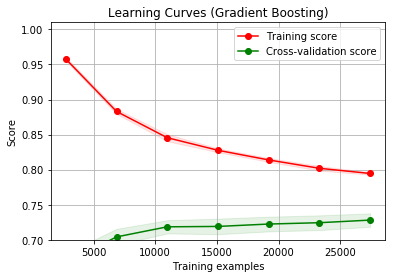

In [43]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 7)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv,scoring = 'roc_auc', n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

X, y = trainSet.iloc[:,:-1], trainSet['label']

title = "Learning Curves (Gradient Boosting)"

cv = StratifiedKFold(n_splits=7, shuffle = True)

estimator = GradientBoostingClassifier(random_state = 42)
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

По графику кросс-валидации видно, что кривая качества выходит на асимпототу(~0.72) начиная с 11к объектов выборки. Остановимся на этом количестве.

In [50]:
trainSet = transformData(trainTable, encoder='LabelEncoder', nrows=11000)

table was transformed!


22. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

In [7]:
def countBalancedClass(labelSet):
    return compute_class_weight(class_weight = 'balanced', classes  = [-1,1], y = labelSet)

In [19]:
balancedClass = countBalancedClass(trainSet['label'])
weigthList = [[1,1],
              [0.5, 2],#4 times
              [0.5, 4],#8 times
             [balancedClass[0], balancedClass[1]],#12 times
              [0.5,8],#16 times
              [0.5,10]#20  times
             ]

for weight in weigthList:
    clf = GradientBoostingClassifier(random_state = 42).fit(trainSet.iloc[:, :-1], trainSet['label'],
                                sample_weight = returnWeightedTarget(list(trainSet['label']), weight))
    preds = clf.predict(holdoutSet.iloc[:, :-1])
    
    print "Confusion Matrix"
    print confusion_matrix(holdoutSet['label'], preds)
    print '*' * 64
    print "Roc-auc = {0}".format(roc_auc_score(holdoutSet['label'], preds))
    print '*' * 64
    print "Classification Report with weight distr = {0}".format(weight)
    print classification_report(holdoutSet['label'], preds)
    print '\n'

Confusion Matrix
[[7373    6]
 [ 615    6]]
****************************************************************
Roc-auc = 0.50442435872
****************************************************************
Classification Report with weight distr = [1, 1]
             precision    recall  f1-score   support

         -1       0.92      1.00      0.96      7379
          1       0.50      0.01      0.02       621

avg / total       0.89      0.92      0.89      8000



Confusion Matrix
[[7276  103]
 [ 563   58]]
****************************************************************
Roc-auc = 0.539719607303
****************************************************************
Classification Report with weight distr = [0.5, 2]
             precision    recall  f1-score   support

         -1       0.93      0.99      0.96      7379
          1       0.36      0.09      0.15       621

avg / total       0.88      0.92      0.89      8000



Confusion Matrix
[[6778  601]
 [ 425  196]]
*************************

Остановимся на сбалансированном распределении весов классов при обучении на данной выборке.

2.2. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [68]:
SamplingStrategies = [
    RandomUnderSampler(ratio = 'majority', random_state=42),
    SMOTE(random_state=42),
    NearMiss(ratio = 'majority', version = 3, random_state=42)
]

for strategy in SamplingStrategies:
    resampledX, resampledY = strategy.fit_sample(train.iloc[:, :-1], train['label'])
    clf = GradientBoostingClassifier(random_state=42).fit(resampledX, resampledY)
    preds = clf.predict(holdoutSet.iloc[:,:-1])
    
    print "Confusion Matrix"
    print confusion_matrix(holdoutSet['label'], preds)
    print '*' * 64
    print "Roc-auc = {0}".format(roc_auc_score(holdoutSet['label'], preds))
    print '*' * 64
    print "Classification Report"
    print classification_report(holdoutSet['label'], preds)
    print '\n'

Confusion Matrix
[[4718 2661]
 [ 228  393]]
****************************************************************
Roc-auc = 0.636116135816
****************************************************************
Classification Report
             precision    recall  f1-score   support

         -1       0.95      0.64      0.77      7379
          1       0.13      0.63      0.21       621

avg / total       0.89      0.64      0.72      8000



Confusion Matrix
[[1638 5741]
 [  43  578]]
****************************************************************
Roc-auc = 0.57636907104
****************************************************************
Classification Report
             precision    recall  f1-score   support

         -1       0.97      0.22      0.36      7379
          1       0.09      0.93      0.17       621

avg / total       0.91      0.28      0.35      8000



Confusion Matrix
[[5938 1441]
 [ 373  248]]
****************************************************************
Roc-auc = 0.6020

Использование сэмплирования приводит к худшим результатам нежели распределение весов, поэтому будет использовать распределение весов в дальнейшем.

3. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [20]:
nanFillsStrategy = ['zero', 'mean']

for filling in nanFillsStrategy:
    print "{0} fill strategy".format(filling)
    trainSet = transformData(trainTable, encoder='LabelEncoder', nanFillStrategy=filling)
    holdoutSet = transformData(holdoutTable, encoder='LabelEncoder', nanFillStrategy=filling)
    
    clf = GradientBoostingClassifier(random_state=42).fit(trainSet.iloc[:, :-1], trainSet['label'],
                    sample_weight = returnWeightedTarget(list(trainSet['label']), [0.5, 8]))
    preds = clf.predict(holdoutSet.iloc[:, :-1])
    print "Confusion Matrix"
    print confusion_matrix(holdoutSet['label'], preds)
    print '*' * 64
    print "Roc-auc = {0}".format(roc_auc_score(holdoutSet['label'], preds))
    print '*' * 64
    print "Classification Report"
    print classification_report(holdoutSet['label'], preds)
    print '\n'

zero fill strategy
table was transformed!
table was transformed!
Confusion Matrix
[[4943 2436]
 [ 191  430]]
****************************************************************
Roc-auc = 0.681152764329
****************************************************************
Classification Report
             precision    recall  f1-score   support

         -1       0.96      0.67      0.79      7379
          1       0.15      0.69      0.25       621

avg / total       0.90      0.67      0.75      8000



mean fill strategy
table was transformed!
table was transformed!
Confusion Matrix
[[5030 2349]
 [ 203  418]]
****************************************************************
Roc-auc = 0.677386036319
****************************************************************
Classification Report
             precision    recall  f1-score   support

         -1       0.96      0.68      0.80      7379
          1       0.15      0.67      0.25       621

avg / total       0.90      0.68      0.75      80

4. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [21]:
trainSet = transformData(trainTable, encoder='OneHot', nanFillStrategy='mean', 
                         nrows = 11000, dataSample = 'withTarget')
holdoutSet = transformData(holdoutTable, encoder='OneHot', nanFillStrategy='mean', 
                           dataSample='withTarget')
trainLabel, holdoutSetLabel = trainSet['label'], holdoutSet['label']
trainSet.drop(['label'], axis = 1, inplace = True)
holdoutSet.drop(['label'], axis = 1, inplace = True)
commonFeatures = featureUnion(list(trainSet.columns), list(holdoutSet.columns))
trainSet, holdoutSet = trainSet[commonFeatures],holdoutSet[commonFeatures]

clf = GradientBoostingClassifier(random_state=42).fit(trainSet, trainLabel,
        sample_weight = returnWeightedTarget(list(trainLabel), [0.5, 8]))
preds = clf.predict(holdoutSet)
print "Confusion Matrix"
print confusion_matrix(holdoutSetLabel, preds)
print '*' * 64
print "Roc-auc = {0}".format(roc_auc_score(holdoutSetLabel, preds))
print '*' * 64
print "Classification Report"
print classification_report(holdoutSetLabel, preds)
print '\n'

table was transformed!
table was transformed!
Confusion Matrix
[[3931 3448]
 [ 143  478]]
****************************************************************
Roc-auc = 0.651227129956
****************************************************************
Classification Report
             precision    recall  f1-score   support

         -1       0.96      0.53      0.69      7379
          1       0.12      0.77      0.21       621

avg / total       0.90      0.55      0.65      8000





5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

In [22]:
#Lasso Feature Selection
def lassoStrategy(X, y):
    selectedFeatures = []
    print 'Getting features with Lasso...'
    lasso = LassoCV().fit(X, y)
    lasso_coefs = lasso.coef_
    print 'Lasso Alpha', lasso.alpha_
    for features, coefs in zip(X.columns, lasso_coefs):
        if coefs > 0:
            selectedFeatures.append(features)
    return selectedFeatures

trainSet = transformData(trainTable,encoder = 'LabelEncoder', nanFillStrategy = 'zero')
holdoutSet = transformData(holdoutTable, encoder = 'LabelEncoder', nanFillStrategy = 'zero')
selectedFeatures = lassoStrategy(trainSet.iloc[:, :-1], trainSet['label'])

clf = GradientBoostingClassifier(random_state=42).fit(trainSet[selectedFeatures], trainSet['label'],
        sample_weight = returnWeightedTarget(list(trainSet['label']), [0.5, 8]))
preds = clf.predict(holdoutSet[selectedFeatures])
print "Confusion Matrix"
print confusion_matrix(holdoutSet['label'], preds)
print '*' * 64
print "Roc-auc = {0}".format(roc_auc_score(holdoutSet['label'], preds))
print '*' * 64
print "Classification Report"
print classification_report(holdoutSet['label'], preds)
print '\n'

table was transformed!
table was transformed!
Getting features with Lasso...
Lasso Alpha 0.0676825173828
Confusion Matrix
[[7285   94]
 [ 617    4]]
****************************************************************
Roc-auc = 0.496851185165
****************************************************************
Classification Report
             precision    recall  f1-score   support

         -1       0.92      0.99      0.95      7379
          1       0.04      0.01      0.01       621

avg / total       0.85      0.91      0.88      8000





In [23]:
#Top correlated Features
trainSet = transformData(trainTable, 
                         catColumns = maxCorrCatFeatures, 
                         encoder = 'LabelEncoder', nanFillStrategy = 'zero')
holdoutSet = transformData(holdoutTable, 
                         catColumns = maxCorrCatFeatures, 
                         encoder = 'LabelEncoder', nanFillStrategy = 'zero')

clf = GradientBoostingClassifier(random_state=42).fit(trainSet.iloc[:,:-1], trainSet['label'],
        sample_weight = returnWeightedTarget(list(trainSet['label']), [0.5, 8]))
preds = clf.predict(holdoutSet.iloc[:, :-1])
print "Confusion Matrix"
print confusion_matrix(holdoutSet['label'], preds)
print '*' * 64
print "Roc-auc = {0}".format(roc_auc_score(holdoutSet['label'], preds))
print '*' * 64
print "Classification Report"
print classification_report(holdoutSet['label'], preds)
print '\n'
                         

table was transformed!
table was transformed!
Confusion Matrix
[[4932 2447]
 [ 184  437]]
****************************************************************
Roc-auc = 0.686043476733
****************************************************************
Classification Report
             precision    recall  f1-score   support

         -1       0.96      0.67      0.79      7379
          1       0.15      0.70      0.25       621

avg / total       0.90      0.67      0.75      8000





6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

In [5]:
trainSet = transformData(trainTable, encoder = 'LabelEncoder', 
                         catColumns = maxCorrCatFeatures,nanFillStrategy = 'zero')
holdoutSet = transformData(holdoutTable, encoder = 'LabelEncoder', 
                           catColumns = maxCorrCatFeatures, nanFillStrategy = 'zero')

table was transformed!
table was transformed!


Сначала запустим Градиентный бустинг со стандартными параметрами

In [7]:
%%time
baseline = GradientBoostingClassifier(random_state=42)
baseline.fit(trainSet.iloc[:, :-1],trainSet['label'], 
             sample_weight = returnWeightedTarget(list(trainSet['label']), [0.5, 8]))
preds = baseline.predict(holdoutSet.iloc[:, :-1])

print "Confusion Matrix"
print confusion_matrix(holdoutSet['label'], preds)
print '*' * 64
print "Roc-auc = {0}".format(roc_auc_score(holdoutSet['label'], preds))
print "Recall = {0}".format(recall_score(holdoutSet['label'], preds, average = 'binary'))
print "Precision = {0}".format(precision_score(holdoutSet['label'], preds, average = 'binary'))
print '*' * 64
print "Classification Report"
print classification_report(holdoutSet['label'], preds)
print '\n'

Confusion Matrix
[[4932 2447]
 [ 184  437]]
****************************************************************
Roc-auc = 0.686043476733
Recall = 0.703703703704
Precision = 0.151525658807
****************************************************************
Classification Report
             precision    recall  f1-score   support

         -1       0.96      0.67      0.79      7379
          1       0.15      0.70      0.25       621

avg / total       0.90      0.67      0.75      8000



Wall time: 54.2 s


Подбор estimators

In [ ]:
%%time
p_test1 = {'learning_rate':[0.15, 0.01, 0.001], 
           'n_estimators':[100,250,500, 750]}
tuning = GridSearchCV(estimator = GradientBoostingClassifier(random_state=42), 
                      param_grid = p_test1, 
                      scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
tuning.fit(trainSet.iloc[:, :-1],trainSet['label'], 
        sample_weight = returnWeightedTarget(list(trainSet['label']), [0.5, 8]))
print tuning.best_params_, tuning.best_score_


preds = tuning.predict(holdoutSet.iloc[:, :-1])

print "Confusion Matrix"
print confusion_matrix(holdoutSet['label'], preds)
print '*' * 64
print "Roc-auc = {0}".format(roc_auc_score(holdoutSet['label'], preds))
print "Recall = {0}".format(recall_score(holdoutSet['label'], preds, average = 'binary'))
print "Precision = {0}".format(precision_score(holdoutSet['label'], preds, average = 'binary'))
print '*' * 64
print "Classification Report"
print classification_report(holdoutSet['label'], preds)
print '\n'

Подбор max_depth

In [6]:
%%time
p_test2 = {'max_depth':[2,4,6]}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(n_estimators=750, 
                                                            learning_rate = 0.01,
                                                            random_state=42),       
            param_grid = p_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)

tuning.fit(trainSet.iloc[:, :-1],trainSet['label'], 
        sample_weight = returnWeightedTarget(list(trainSet['label']), [0.5, 8]))
print tuning.best_params_, tuning.best_score_

preds = tuning.predict(holdoutSet.iloc[:, :-1])

print "Confusion Matrix"
print confusion_matrix(holdoutSet['label'], preds)
print '*' * 64
print "Roc-auc = {0}".format(roc_auc_score(holdoutSet['label'], preds))
print "Recall = {0}".format(recall_score(holdoutSet['label'], preds, average = 'binary'))
print "Precision = {0}".format(precision_score(holdoutSet['label'], preds, average = 'binary'))
print '*' * 64
print "Classification Report"
print classification_report(holdoutSet['label'], preds)
print '\n'

{'max_depth': 2} 0.727515801815
Confusion Matrix
[[4085 3294]
 [ 135  486]]
****************************************************************
Roc-auc = 0.668103372084
Recall = 0.782608695652
Precision = 0.128571428571
****************************************************************
Classification Report
             precision    recall  f1-score   support

         -1       0.97      0.55      0.70      7379
          1       0.13      0.78      0.22       621

avg / total       0.90      0.57      0.67      8000



Wall time: 34min 2s


Подбор min_samples_split и min_samples_leaf

In [8]:
%%time
p_test3 = {'min_samples_split':[2, 8, 40, 80], 
           'min_samples_leaf':[1, 3, 7]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01, n_estimators=750,
                                                            max_depth=2,random_state=42), 
            param_grid = p_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)

tuning.fit(trainSet.iloc[:, :-1],trainSet['label'], 
        sample_weight = returnWeightedTarget(list(trainSet['label']), [0.5, 8]))
print tuning.best_params_, tuning.best_score_

preds = tuning.predict(holdoutSet.iloc[:, :-1])

print "Confusion Matrix"
print confusion_matrix(holdoutSet['label'], preds)
print '*' * 64
print "Roc-auc = {0}".format(roc_auc_score(holdoutSet['label'], preds))
print "Recall = {0}".format(recall_score(holdoutSet['label'], preds, average = 'binary'))
print "Precision = {0}".format(precision_score(holdoutSet['label'], preds, average = 'binary'))
print '*' * 64
print "Classification Report"
print classification_report(holdoutSet['label'], preds)
print '\n'

{'min_samples_split': 40, 'min_samples_leaf': 1} 0.727515945053
Confusion Matrix
[[4085 3294]
 [ 135  486]]
****************************************************************
Roc-auc = 0.668103372084
Recall = 0.782608695652
Precision = 0.128571428571
****************************************************************
Classification Report
             precision    recall  f1-score   support

         -1       0.97      0.55      0.70      7379
          1       0.13      0.78      0.22       621

avg / total       0.90      0.57      0.67      8000



Wall time: 40min 17s


Подбор max_features

In [9]:
%%time
p_test4 = {'max_features':['auto','log2', None]}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.15, n_estimators=750,
                                                            min_samples_split=40, 
                                                            min_samples_leaf=1, 
                                                            random_state=42), 
param_grid = p_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
tuning.fit(trainSet.iloc[:, :-1],trainSet['label'], 
        sample_weight = returnWeightedTarget(list(trainSet['label']), [0.5, 8]))
print tuning.best_params_, tuning.best_score_

preds = tuning.predict(holdoutSet.iloc[:, :-1])

print "Confusion Matrix"
print confusion_matrix(holdoutSet['label'], preds)
print '*' * 64
print "Roc-auc = {0}".format(roc_auc_score(holdoutSet['label'], preds))
print "Recall = {0}".format(recall_score(holdoutSet['label'], preds, average = 'binary'))
print "Precision = {0}".format(precision_score(holdoutSet['label'], preds, average = 'binary'))
print '*' * 64
print "Classification Report"
print classification_report(holdoutSet['label'], preds)
print '\n'

{'max_features': 'log2'} 0.703501985097
Confusion Matrix
[[6460  919]
 [ 411  210]]
****************************************************************
Roc-auc = 0.606810815128
Recall = 0.338164251208
Precision = 0.186005314438
****************************************************************
Classification Report
             precision    recall  f1-score   support

         -1       0.94      0.88      0.91      7379
          1       0.19      0.34      0.24       621

avg / total       0.88      0.83      0.85      8000



Wall time: 10min 51s


Подбор subsample

In [ ]:
%%time
p_test5= {'subsample':[0.85, 0.95, 1]}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.15, n_estimators= 100,
                                                            max_depth=4, min_samples_split=80, 
                                                            min_samples_leaf=1,max_features='auto' , 
                                                            random_state=42), 
                                    param_grid = p_test5, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
tuning.fit(trainSet.iloc[:, :-1],trainSet['label'], 
        sample_weight = returnWeightedTarget(list(trainSet['label']), [0.5, 8]))
print tuning.best_params_, tuning.best_score_

preds = tuning.predict(holdoutSet.iloc[:, :-1])

print "Confusion Matrix"
print confusion_matrix(holdoutSet['label'], preds)
print '*' * 64
print "Roc-auc = {0}".format(roc_auc_score(holdoutSet['label'], preds))
print "Recall = {0}".format(recall_score(holdoutSet['label'], preds, average = 'binary'))
print "Precision = {0}".format(precision_score(holdoutSet['label'], preds, average = 'binary'))
print '*' * 64
print "Classification Report"
print classification_report(holdoutSet['label'], preds)
print '\n'

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [ ]:
predictors=list(trainSet.iloc[:, :-1])
feat_imp = pd.Series(tuning.feature_importances_, predictors).sort_values(ascending=False)[:15]
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [ ]:
print confusion_matrix(holdoutSet['label'], preds)

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.